In [105]:
import os
import sys
import math
import glob
import time
import pickle
import random
import numpy as np
import pandas as pd
from Bio.PDB import *
from Bio.PDB.DSSP import DSSP
from Bio.PDB.Selection import unfold_entities
from Bio.PDB.NeighborSearch import NeighborSearch
from Bio import pairwise2
from Bio.Align import substitution_matrices
blosum62 = substitution_matrices.load("BLOSUM62")
import statistics as st

import subprocess as sp
import multiprocessing as mp
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA
from sklearn import linear_model
from scipy.stats import pearsonr
from scipy.stats import spearmanr

import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 20})
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from PIL import Image
import io

sb.set(font_scale = 1.8)
sb.set_style("whitegrid")

def load_resfile(file):
    res = {}
    for line in open(bsfolder+'results/'+file):
        code = line.split()[-1].split('/')[-1].split('_')[0]
        dockq = float(line.split()[1])
        if not code in res: res[code] = []
        res[code].append(dockq)
    return res

bsfolder = '/home/gabriele/Desktop/BindingSite_docking/'
codelist = [line.rstrip() for line in open(bsfolder+'list_dimers')]

chainlist = []
for code in codelist:
    chainlist.append(code+'_u1')
    chainlist.append(code+'_u2')
    
tags = ['BIP2', 'ISP_SVM', 'PRE', 
        'JET_CL', 'JET_TR', 'SPP']

postag = {1:'realb',
          12:'BIP2', 13:'ISP_SVM', 15:'PRE', 
          16:'JET_CL', 17:'JET_TR', 18:'SPP'}

tagpos = {tag:n+11 for n, tag in enumerate(['BIP1', 'BIP2', 'ISP_SVM', 'ISP_CRF', 
                                            'PRE', 'JET_CL', 'JET_TR', 'SPP'])}

dockqs = {'base':load_resfile('summary_dockq_base'), 
          'aace':load_resfile('summary_dockq_aace'),
          'realb':load_resfile('summary_dockq_1'),
          'r1075':load_resfile('summary_dockq_2'), 
          'r105':load_resfile('summary_dockq_3'),
          'r1025':load_resfile('summary_dockq_4'),
          'r0751':load_resfile('summary_dockq_5'), 
          'r051':load_resfile('summary_dockq_6'), 
          'r0251':load_resfile('summary_dockq_7'),
          'r0505':load_resfile('summary_dockq_8'), 
          'r05025':load_resfile('summary_dockq_9'), 
          'r02505':load_resfile('summary_dockq_10'),
          'BIP1':load_resfile('summary_dockq_11'), 
          'BIP2':load_resfile('summary_dockq_12'),
          'ISP_SVM':load_resfile('summary_dockq_13'), 
          'ISP_CRF':load_resfile('summary_dockq_14'),
          'PRE':load_resfile('summary_dockq_15'),
          'JET_CL':load_resfile('summary_dockq_16'), 
          'JET_TR':load_resfile('summary_dockq_17'),
          'SPP':load_resfile('summary_dockq_18')}

name_refine = {
    'base':'Gramm Baseline',
    'aace':'Gramm+AACE18',
    'realb':'Real Interface',
    'r1075':'TPR1.0-PPV0.75', 
    'r105':'TPR1.0-PPV0.5', 
    'r1025':'TPR1.0-PPV0.25', 
    'r0751':'TPR0.75-PPV1.0', 
    'r051':'TPR0.5-PPV1.0', 
    'r0251':'TPR0.25-PPV1.0', 
    'r0505':'TPR0.5-PPV0.5', 
    'r05025':'TPR0.5-PPV0.25', 
    'r02505':'TPR0.25-PPV0.5',
    'ISP_SVM':'ISPRED4',
    'ISP_CRF':'ISPRED4 CRF',
    'BIP1':'BIPSPI 1',
    'BIP2':'BIPSPI',
    'PRE':'PREDUS',
    'JET_CL':'dynJET Cluster',
    'JET_TR':'dynJET Trace',
    'SPP':'SPPIDER'}

palette1 = ['#ff7f00', '#377eb8']
palette2 = ['#007b04','#aa3fff','#c79a00', '#00d8ff']
palette3 = ['#895dca', #Purple
            '#5ddcde', #Cyan
            '#cb5838', #Bordoux
            '#539c56', #Darkgreen
            '#a3c85d', #Lightgreen
            '#c79a00', #Orange
            '#afafaf'] #Grey
            
palette4 = ['#5b80ff', '#c79a00']
palette5 = ['#e5e5e5', #White
            '#56ce96', #Waterygreen
            '#895dca', #Purple
            '#5ddcde', #Cyan
            '#539c56', #Darkgreen
            '#a3c85d', #Lightgreen
            '#cb5838', #Bordoux
            '#c79a00'] #Orange
palette6 = ['#895dca', #Purple
            '#5ddcde', #Cyan
            '#cb5838', #Bordoux
            '#539c56', #Darkgreen
            '#a3c85d', #Lightgreen
            '#c79a00'] #Orange


In [106]:
##### TOP 10 NON-ACCEPTABLE REAL INTERFACE
for code in dockqs['realb']:
    if max(dockqs['realb'][code][:10]) < 0.23:
        print (code, max(dockqs['realb'][code][:10]))

1gcq 0.19
1ib1 0.152
1jiw 0.18
1k5g 0.201
1kgy 0.094
1lb2 0.202
1lfd 0.197
1nql 0.128
1r8s 0.147
1uad 0.128
1wrd 0.116
1y64 0.17
1y8x 0.174
2abz 0.165
2aq3 0.085
2c0l 0.202
2ch4 0.098
2i25 0.114
2ido 0.105
2nxn 0.089
2uy7 0.115
2vrr 0.132
2xwb 0.206
3av0 0.224
3cw2 0.012
3f1p 0.179
3fpu 0.084
3k1i 0.102
3l4q 0.117
3oun 0.172
3t5g 0.225
3znz 0.122
4c0o 0.067
4c6t 0.157
4ct4 0.194
4etw 0.101
4f7g 0.132
4ilh 0.188
4lsx 0.073
4o4b 0.119
4x6q 0.11
4xoi 0.157


In [107]:
##### DOCKING DIFFICULTY #####
def get_int(ch, opp):
    oppatoms = [atom for res in opp for atom in res]
    ns = NeighborSearch(oppatoms)
    
    intids = []
    for res in ch: 
        for atom in res:
            center = atom.get_coord()
            neighbors = ns.search(center, 10, 'R')
            if len(neighbors) != 0:
                intids.append(res.get_id()[1])
                break
    return intids

def get_contacts(strA,strB):
    contacts = []
    atomsA = [atom for res in strA for atom in res]
    atomsB = [atom for res in strB for atom in res]
    
    ns = NeighborSearch(atomsB)
    for res in strA:
        resnumA = res.get_id()[1]
        for atom in res: 
            atom = atom.get_coord()
            nlist = ns.search(atom, 5, 'R')
            for res in nlist:
                resnumB = res.get_id()[1]
                contact = str(resnumA)+'_'+str(resnumB)
                if contact not in contacts:
                    contacts.append(contact)
    
    ns = NeighborSearch(atomsA)
    for res in strB:
        nlist = []
        resnumB = res.get_id()[1]
        for atom in res: 
            atom = atom.get_coord()
            nlist = ns.search(atom, 5, 'R')
            for res in nlist:
                resnumA = res.get_id()[1]
                contact = str(resnumA)+'_'+str(resnumB)
                if contact not in contacts:
                    contacts.append(contact)
    return contacts                 

lengths = {}
hardness = {}
interfaces = {}
h = m = e = 0
p = PDBParser(QUIET=True)
for code in codelist: 
    unbound = bsfolder+'data/processed_b4/'+code+'_uc.pdb'
    bound = bsfolder+'data/processed_b4/'+code+'_bc.pdb'
    ustr = p.get_structure('', unbound)
    bstr = p.get_structure('', bound)
    uresA = unfold_entities(ustr[0]['A'], 'R')
    uresB = unfold_entities(ustr[0]['B'], 'R')
    bresA = unfold_entities(bstr[0]['A'], 'R')
    bresB = unfold_entities(bstr[0]['B'], 'R')
    lengths[code] = [len(bresA), len(bresB)]
    bintA = get_int(bresA, bresB)
    bintB = get_int(bresB, bresA)
    
    acc = 0
    for rid in bintA:
        bcarb = ucarb = ''
        if 'CA' in bstr[0]['A'][rid]:
            bcarb = bstr[0]['A'][rid]['CA']
        if 'CA' in ustr[0]['A'][rid]:
            ucarb = ustr[0]['A'][rid]['CA']
        if bcarb != '' and ucarb != '': 
            acc += (bcarb-ucarb)
        
    for rid in bintB:
        bcarb = ucarb = ''
        if 'CA' in bstr[0]['B'][rid]:
            bcarb = bstr[0]['B'][rid]['CA']
        if 'CA' in ustr[0]['B'][rid]:
            ucarb = ustr[0]['B'][rid]['CA']
        if bcarb != '' and ucarb != '':
            acc += (bcarb-ucarb)
            
    iRMSD = acc/(len(bintA)+len(bintB))
    
    if iRMSD > 2.2:
        hardness[code] = ['H', iRMSD, None]
    elif iRMSD > 1.5:
        hardness[code] = ['M', iRMSD, None]
    else:
        bresA = [bstr[0]['A'][rid] for rid in bintA]
        bresB = [bstr[0]['B'][rid] for rid in bintB]
        contb = set(get_contacts(bresA,bresB))
        uintA = get_int(uresA, uresB)
        uintB = get_int(uresB, uresA)
        uresA = [ustr[0]['A'][rid] for rid in uintA]
        uresB = [ustr[0]['B'][rid] for rid in uintB]
        contu = set(get_contacts(uresA,uresB))
        conserved = contb.intersection(contu)
        nonnat = len(contu)-len(conserved)
        F_nonnat = nonnat/len(contu)
        if F_nonnat < 0.4:
            hardness[code] = ['E', iRMSD, F_nonnat]
        else: 
            hardness[code] = ['M', iRMSD, F_nonnat]
            
h = m = e = 0
hard = []
medium = []
rigid_body = []
for key in hardness:
    if hardness[key][0] == 'H': 
        h += 1
        hard.append(key)
    elif hardness[key][0] == 'M': 
        m += 1
        medium.append(key)
    else: 
        e += 1
        rigid_body.append(key)

#with open('hardness.pkl', 'wb') as out:
#    pickle.dump([hard, medium, rigid_body], out)
        
        
print ('Whole dataset\n'
       'Hard targets:{}\n'
       'Medium targets:{}\n'
       'Rigid-Body targets:{}\n\n'.format(h,m,e))

h = m = e = 0
method_fail = []
for key in dockqs['realb']: 
    if max(dockqs['realb'][key][:10])<0.23:
        method_fail.append(key)
        if hardness[key][0] == 'H': h += 1
        elif hardness[key][0] == 'M': m += 1
        else: e += 1
        
print ('Real interface docking fails (Top10)\n'
       'Hard targets:{}\n'
       'Medium targets:{}\n'
       'Rigid-Body targets:{}\n\n'.format(h,m,e))

Whole dataset
Hard targets:31
Medium targets:72
Rigid-Body targets:116


Real interface docking fails (Top10)
Hard targets:17
Medium targets:17
Rigid-Body targets:8




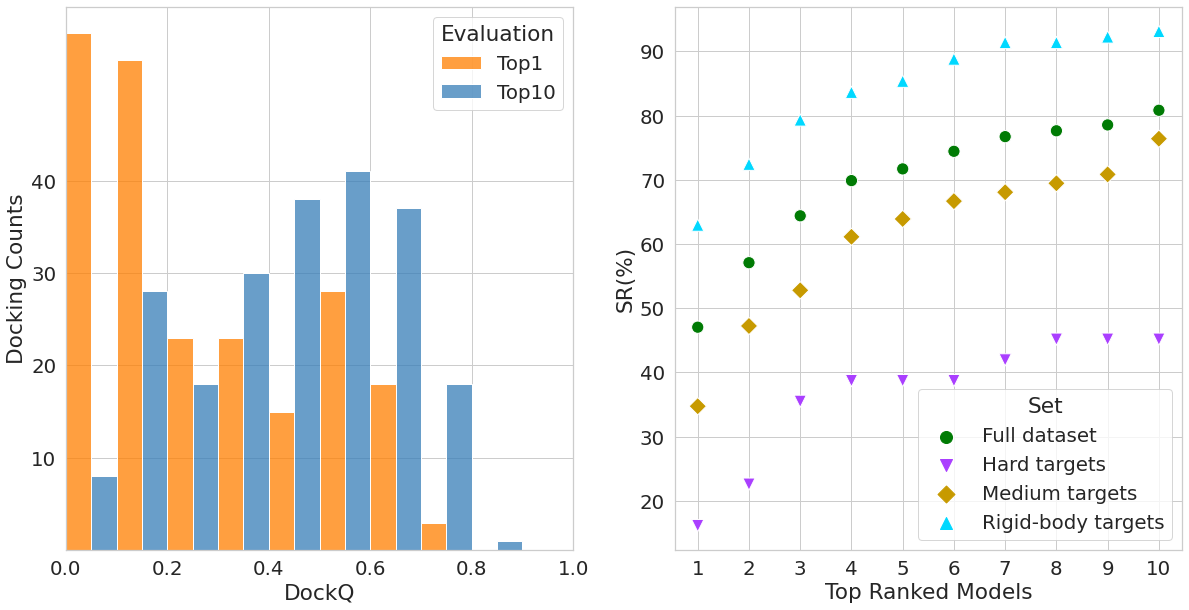

In [128]:
def get_firstmodel(key, lbl):
    results = [dockqs[key1][key][0] for key in dockqs[key1]]    
    return [results[key] for key in results]

def success_rate(label, allowed, succ_rates):
    succ_rates['TargetSet'] += [label]*10
    succ_rates['TopMod.'] += list(range(1,11))
    for top in range(1,11):
        res = {key:max(dockqs['realb'][key][:top])\
                for key in dockqs['realb']\
                if key in allowed}
        success = [1 if res[key] >= 0.23 else 0 for key in res]
        succ_rates['SR(%)'].append((sum(success)/len(success))*100)
    return succ_rates

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

results = [dockqs['realb'][key][0] for key in dockqs['realb']]
results += [max(dockqs['realb'][key][:10]) for key in dockqs['realb']]

labels = ['Top1' for n in dockqs['realb']]
labels += ['Top10' for n in dockqs['realb']]

data = {'DockQ':results, 'Evaluation':labels}
data = pd.DataFrame(data)

sb.set_palette(palette=palette1)
sb.histplot(x='DockQ', data=data, hue='Evaluation', 
            kde=False, bins=np.arange(0.0, 1.025, 0.1), 
            multiple='dodge', ax=axes[0])

axes[0].set_xlabel("DockQ")
axes[0].set_ylabel("Docking Counts")
axes[0].set_yticks(np.arange(10,41,10))
axes[0].set_xlim(0,1)

succ_rates = {'SR(%)':[], 'TopMod.':[], 'TargetSet':[]}
succ_rates = success_rate('Full dataset', codelist, succ_rates)
succ_rates = success_rate('Hard targets', hard, succ_rates)
succ_rates = success_rate('Medium targets', medium, succ_rates)
succ_rates = success_rate('Rigid-body targets', rigid_body, succ_rates)

succ_rates = pd.DataFrame(succ_rates)
sb.set_palette(palette=palette2)
sb.scatterplot(x='TopMod.', y='SR(%)', hue='TargetSet',
               style='TargetSet', data=succ_rates, s=150,
               markers=['o', 'v', 'D', '^'], ax=axes[1])

axes[1].set_ylabel("SR(%)")
axes[1].set_xlabel("Top Ranked Models")
axes[1].set_xticks(np.arange(1,11))
axes[1].legend(title='Set', markerscale=2)
fig.savefig(bsfolder+'pictures/real_interfaces_docking_statistics.png')

#png1 = io.BytesIO()
#fig.savefig(png1, format="png")

# Load this image into PIL
#png2 = Image.open(png1)

# Save as TIFF
#png2.save(bsfolder+'pictures/gramm_realinterface.tiff')
#png1.close()

BIP2 12
Worst AUC 0.31625789138740573 Baseline 0.20674548966037024
Non-random prediction chains: 365
0.4873523293817765
ISP_SVM 13
Worst AUC 0.19233786359701274 Baseline 0.2274214489742924
Non-random prediction chains: 316
0.2899735102994424
PRE 15
Non-random prediction chains: 301
JET_CL 16
Worst AUC 0.22291776809462782 Baseline 0.22078053213510376
Non-random prediction chains: 295
0.30272714212939256
JET_TR 17
Worst AUC 0.17883029481795124 Baseline 0.22771407912405744
Non-random prediction chains: 302
0.26558324957503154
SPP 18
Worst AUC 0.2394067007933488 Baseline 0.22470751945575426
Non-random prediction chains: 346
0.32408828637540676


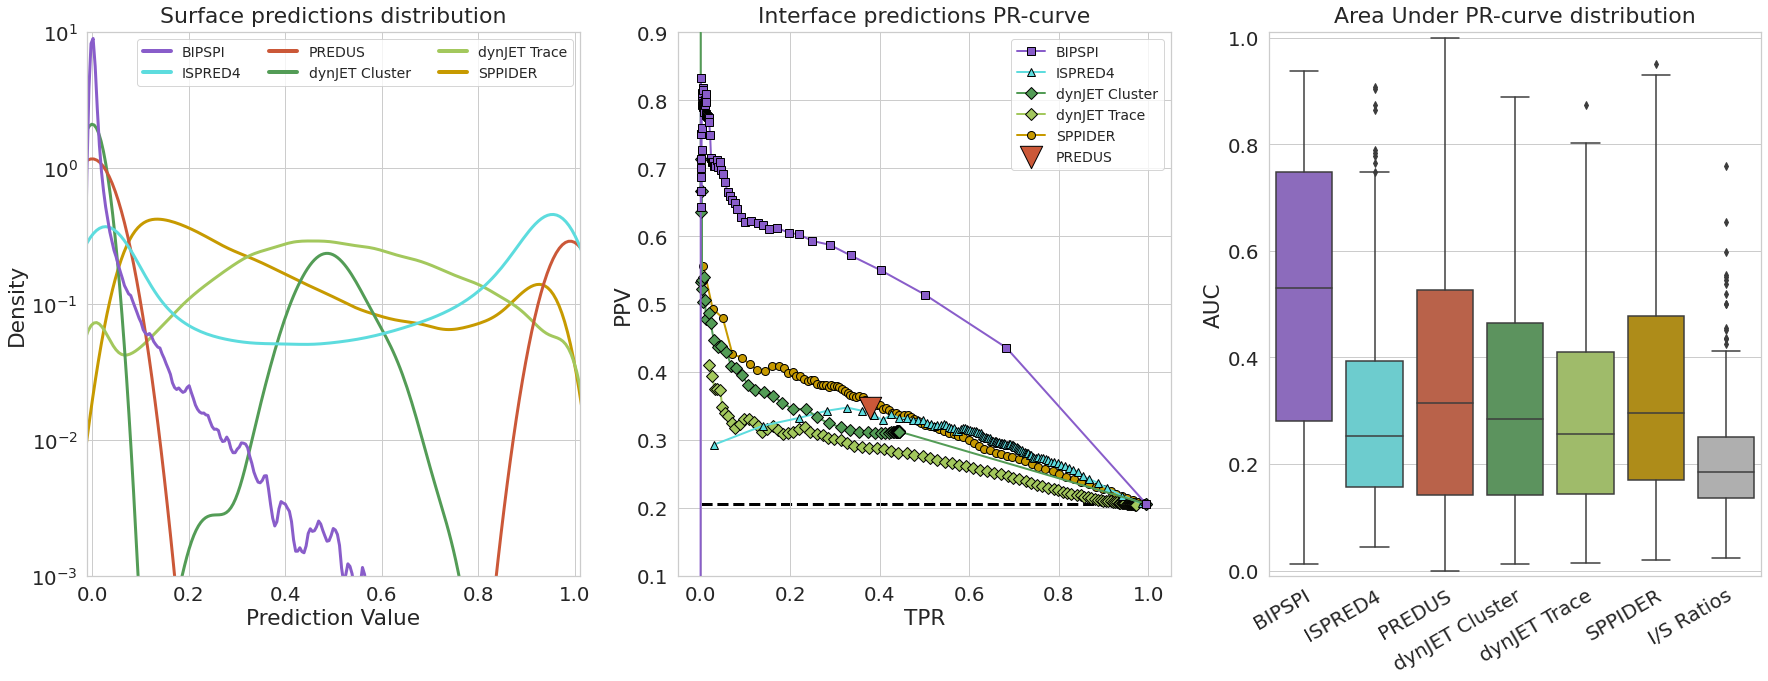

In [113]:
sb.set_palette(palette=palette3)
def manual_pr_stats(scores, allscores):
    TPR = []
    PPV = []
    array = np.array(scores)
    thresholds = np.array(allscores)    
    thresholds = thresholds[thresholds.argsort()[::-1]]

    for thr in thresholds:
        TP = FP = FN = TN = 0
        for pair in array: 
            if pair[0] >= thr: 
                if pair[1] == 1.0: TP += 1
                else: FP += 1
            else:
                if pair[1] == 1.0: FN += 1
                else: TN += 1
        if TP+FP==0:
            TPR.append(TP/(TP+FN))
            PPV.append(2.0)
            continue
        TPR.append(TP/(TP+FN))
        PPV.append(TP/(TP+FP))
    return {'TPR':TPR, 'PPV':PPV}      

def avg_curves(stats):
    stats['TPR'] = np.array(stats['TPR'])
    stats['PPV'] = np.array(stats['PPV'])
    stats['TPR'] = np.sum(stats['TPR'], axis=0)/440

    PPVs = []
    for x in range(len(stats['PPV'][0])):
        acc = 0
        count = 0
        for y in range(len(stats['PPV'])):
            if stats['PPV'][y][x] != 2.0:
                acc += stats['PPV'][y][x]
                count += 1
        if count > 0: PPVs.append(acc/count)
        else: stats['TPR'] = stats['TPR'][1:]
    stats['PPV'] = PPVs
    return stats

def BSpred_stats(label):

    n = tagpos[label]
    print (label, n)
    
    allpred = []
    statsmap = {}
    surfaces = {}
    allscores = []
    interfaces = {}
    chainscores1 = []
    chainscores2 = [] 
    nonrandcount = 0
    worstcount = 0
    worstbase = 0
    
    ##### iterate over all dataset to find all possible thresholds
    for code in chainlist:
        labelfile = bsfolder+'data/formatted_labels/'+code+'.site'
        isp = [float(line.split()[n]) if line.split()[n] != '1.0'\
            else 0.99 for line in open(labelfile)]
        rsa = [float(line.split()[0]) for line in open(labelfile)]
        for lp, acc in zip(isp, rsa):
            if acc < 0.2: continue
            allscores.append(lp)
    allscores = list(set(allscores))
    
    ##### iterate again to calculate stats
    allstats = {'PPV':[], 'TPR':[]}
    worststats = {'PPV':[], 'TPR':[]}
    for code in chainlist:
        pdbcode = code[:4]
        labelfile = bsfolder+'data/formatted_labels/'+code+'.site'
        isp = [float(line.split()[n]) if line.split()[n] != '1.0'\
            else 0.99 for line in open(labelfile)]
        ist = [float(line.split()[1]) for line in open(labelfile)]
        rsa = [float(line.split()[0]) for line in open(labelfile)]
        
        ##### store surface sizes
        if pdbcode not in surfaces: 
            surfaces[pdbcode] = [sum([1 for line in open(labelfile)\
                if float(line.split()[0]) > 0.2])]
        else: 
            surfaces[pdbcode].append(sum([1 for line in open(labelfile)\
                if float(line.split()[0]) > 0.2]))
            
        ##### store interface sizes   
        if pdbcode not in interfaces: 
            interfaces[pdbcode] = [sum([float(line.split()[1])\
                for line in open(labelfile) if float(line.split()[0]) > 0.2])]
        else: 
            interfaces[pdbcode].append(sum([float(line.split()[1])\
                for line in open(labelfile) if float(line.split()[0]) > 0.2]))
            
        for lp, lt, acc in zip(isp, ist, rsa):
            if acc < 0.2: continue
            allpred.append(lp)
            if '_u1' in code: chainscores1.append([lp, lt])
            else: chainscores2.append([lp, lt])

        if '_u2' in code:
            ##### proportion of interface residues
            base1 = np.sum(np.array(chainscores1)[:,1])/len(chainscores1)
            base2 = np.sum(np.array(chainscores2)[:,1])/len(chainscores2)
            
            ##### calculate single protein stats (chain1) and remove missing PPV points
            refstats1 = {}
            stats1 = manual_pr_stats(chainscores1, allscores)
            if stats1['PPV'][0] == 2.0:
                for i, ppv in enumerate(stats1['PPV']):
                    if ppv != 2.0:
                        refstats1['TPR'] = stats1['TPR'][i:]
                        refstats1['PPV'] = stats1['PPV'][i:]
                        break
            else: 
                refstats1['TPR'] = stats1['TPR']
                refstats1['PPV'] = stats1['PPV']
            
            ##### calculate single protein stats (chain2) and remove missing PPV points
            refstats2 = {}
            stats2 = manual_pr_stats(chainscores2, allscores)
            if stats2['PPV'][0] == 2.0:
                for i, ppv in enumerate(stats2['PPV']):
                    if ppv != 2.0:
                        refstats2['TPR'] = stats2['TPR'][i:]
                        refstats2['PPV'] = stats2['PPV'][i:]
                        break
            else: 
                refstats2['TPR'] = stats2['TPR']
                refstats2['PPV'] = stats2['PPV']
            
            ##### complexes with no prediction different from 0 are given constant PPV between 1 and 0 TPR
            if len(refstats1['PPV']) <= 2:
                refstats1['TPR'] = [0.0]+refstats1['TPR']
                refstats1['PPV'] = refstats1['PPV']*2
            if len(refstats2['PPV']) <= 2:
                refstats2['TPR'] = [0.0]+refstats2['TPR']
                refstats2['PPV'] = refstats2['PPV']*2
            
            ##### calculate AUC for single chains, save individual chain AUCs, 
            ##### compare to chain random prediction baseline and gather worst AUC 
            ##### generating chains to do a dataset-wide average of those chains only
            statsmap[pdbcode] = {}
            if label != 'PRE':
                auc1 = auc(refstats1['TPR'], refstats1['PPV'])
                auc2 = auc(refstats2['TPR'], refstats2['PPV'])
                statsmap[pdbcode]['PR-AUC'] = [auc1, auc2]
                if auc1 > base1: nonrandcount += 1
                if auc2 > base2: nonrandcount += 1
                if auc1 > auc2:
                    worststats['TPR'].append(stats1['TPR'])
                    worststats['PPV'].append(stats1['PPV'])
                    worstcount += len(chainscores1)
                    worstbase += np.sum(np.array(chainscores1)[:,1])
                else:   
                    worststats['TPR'].append(stats2['TPR'])
                    worststats['PPV'].append(stats2['PPV'])
                    worstcount += len(chainscores2)
                    worstbase += np.sum(np.array(chainscores2)[:,1])
            ##### compare PPV instead in case of PREDUS
            else:
                if refstats1['PPV'][0] > base1: nonrandcount += 1
                if refstats2['PPV'][0] > base2: nonrandcount += 1
            
            ##### save individual chains PPV
            statsmap[pdbcode]['PPVs'] = [refstats1['PPV'][0], refstats2['PPV'][0]]
            statsmap[pdbcode]['scores'] = []
            statsmap[pdbcode]['scores'].append(np.array(chainscores1))
            statsmap[pdbcode]['scores'].append(np.array(chainscores2))
            
            ##### stack dataset wide statistics  
            allstats['TPR'].append(stats1['TPR'])
            allstats['TPR'].append(stats2['TPR'])
            allstats['PPV'].append(stats1['PPV'])
            allstats['PPV'].append(stats2['PPV'])
            chainscores1 = []
            chainscores2 = []
    
    ##### calculate average points for PR-curves
    allstats = avg_curves(allstats)
    if label != 'PRE':
        worststats = avg_curves(worststats)
        print ('Worst AUC', auc(worststats['TPR'], worststats['PPV']), 
               'Baseline', worstbase/worstcount)     
    print ('Non-random prediction chains:', nonrandcount)
    
    return allstats, statsmap, surfaces, interfaces, allpred


fig, axes = plt.subplots(1, 3, figsize=(30, 10))
j = 0
ms = 8
ds = 500
labels = []
handles = []
metricdic = {}
all_pred_method = {'Predictions':[], 'Method':[]}

aucs = {'AUC':[], 'Method':[]}
ordermap = {'BIP1':6, 'BIP2':7, 'ISP_SVM':3, 
            'ISP_CRF':8, 'PRE':5, 'JET_CL':4, 
            'JET_TR':2, 'SPP':1}
markermap = {'BIP1':'s', 'BIP2':'s', 'ISP_SVM':'^', 
             'ISP_CRF':'^', 'PRE':'v', 'JET_CL':'D', 
             'JET_TR':'D', 'SPP':'o'}

for tag in tags:
    z = ordermap[tag]
    m = markermap[tag]
    allstats, mapping, surfaces, interfaces, allpred = BSpred_stats(tag)
    metricdic[tag] = mapping
    all_pred_method['Predictions'] += allpred
    all_pred_method['Method'] += [name_refine[tag]]*len(allpred)
    handles.append(Line2D([0], [0], lw=4, color='C'+str(j)))
    labels.append(name_refine[tag])
    #if tag == 'ISP_SVM': allstats_ispdim = allstats
    if tag == 'PRE':
        for key in allstats: allstats[key] = [allstats[key][0]]
        axes[1].scatter(allstats['TPR'], allstats['PPV'], 
                        marker=m, s=ds, edgecolors='black', 
                        c='C'+str(j), zorder=z, label=name_refine[tag])
        for code in mapping:
            aucs['AUC'] += mapping[code]['PPVs']
            aucs['Method'] += [name_refine[tag]]*2
        j += 1
        continue    
        
    axes[1].plot(allstats['TPR'], allstats['PPV'], 
                 marker=m, linewidth=2, markersize=ms, mec='black', 
                 c='C'+str(j), zorder=z, label=name_refine[tag])
    print (auc(allstats['TPR'], allstats['PPV']))
    for code in mapping:
        aucs['AUC'] += mapping[code]['PR-AUC']
        aucs['Method'] += [name_refine[tag]]*2
    j += 1

for code in surfaces:
    ratio1 = interfaces[code][0]/surfaces[code][0]
    ratio2 = interfaces[code][1]/surfaces[code][1]
    aucs['AUC'] += [ratio1, ratio2]
    aucs['Method'] += ['I/S Ratios']*2

sb.kdeplot(x='Predictions', hue='Method', data=all_pred_method, lw='3', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_xlim(-0.01,1.01)
axes[0].set_ylim(0.001,10)
axes[0].set_xlabel('Prediction Value')
axes[0].legend(handles, labels, loc='upper right', prop={'size': 14}, ncol=3)
axes[0].set_title('Surface predictions distribution', 
                  fontdict={'fontsize':22, 
                            'verticalalignment':'bottom'})

axes[1].set_title('Interface predictions PR-curve', 
                  fontdict={'fontsize':22, 
                            'verticalalignment':'bottom'})
axes[1].plot([0, 1], [allstats['PPV'][-1], allstats['PPV'][-1]],
             ls="--", lw='3', zorder=0, color='black')
axes[1].set_ylabel('PPV')
axes[1].set_xlabel('TPR')
axes[1].set_ylim(0.1,0.9)
axes[1].legend(prop={'size': 14})

g = sb.boxplot(x='Method', y='AUC', data=aucs, ax=axes[2])
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=30, 
         ha="right", rotation_mode="anchor")

axes[2].set_ylabel('AUC')
axes[2].set_ylim(-0.01,1.01)
plt.subplots_adjust(wspace=0.2)
axes[2].set_title('Area Under PR-curve distribution', 
                  fontdict={'fontsize':22, 
                            'verticalalignment':'bottom'})



fig.savefig(bsfolder+'pictures/interface_prediction_statistics.png', bbox_inches='tight')

Gramm Baseline&0.02&0.04&0.08&2.73&0.038&0.072&0.104&5.45\\
Gramm+AACE18&0.02&0.07&0.11&6.82&0.06&0.132&0.173&18.18\\
BIPSPI&0.04&0.1&0.14&12.73&0.081&0.169&0.195&25.45\\
ISPRED4&0.03&0.04&0.05&1.82&0.043&0.086&0.115&8.18\\
dynJET Cluster&0.02&0.04&0.07&2.73&0.029&0.065&0.094&5.0\\
dynJET Trace&0.02&0.06&0.1&5.0&0.043&0.104&0.149&11.36\\
PREDUS&0.03&0.06&0.1&4.55&0.037&0.096&0.143&10.45\\
SPPIDER&0.02&0.05&0.08&4.55&0.04&0.094&0.136&11.36\\
Real Interface&0.2&0.28&0.2&46.82&0.468&0.446&0.197&80.45\\
TPR1.0-PPV0.75&0.19&0.25&0.19&40.0&0.449&0.423&0.198&77.73\\
TPR0.75-PPV1.0&0.16&0.22&0.16&35.45&0.385&0.377&0.196&72.73\\
TPR1.0-PPV0.5&0.12&0.18&0.16&25.0&0.3&0.345&0.194&66.36\\
TPR0.5-PPV1.0&0.14&0.21&0.17&33.18&0.305&0.339&0.194&66.36\\
TPR1.0-PPV0.25&0.07&0.1&0.1&6.82&0.128&0.185&0.158&25.45\\
TPR0.25-PPV1.0&0.1&0.14&0.12&17.73&0.198&0.255&0.182&42.73\\


/home/gabriele/anaconda3/envs/MLenv/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[103, 177, 103, 177, 88, 171, 78, 160, 55, 146, 73, 146, 15, 56, 39, 94]


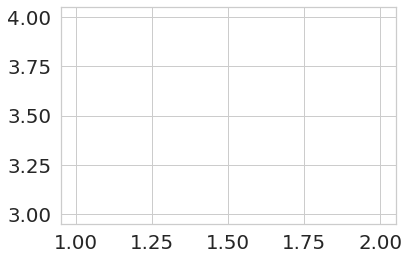

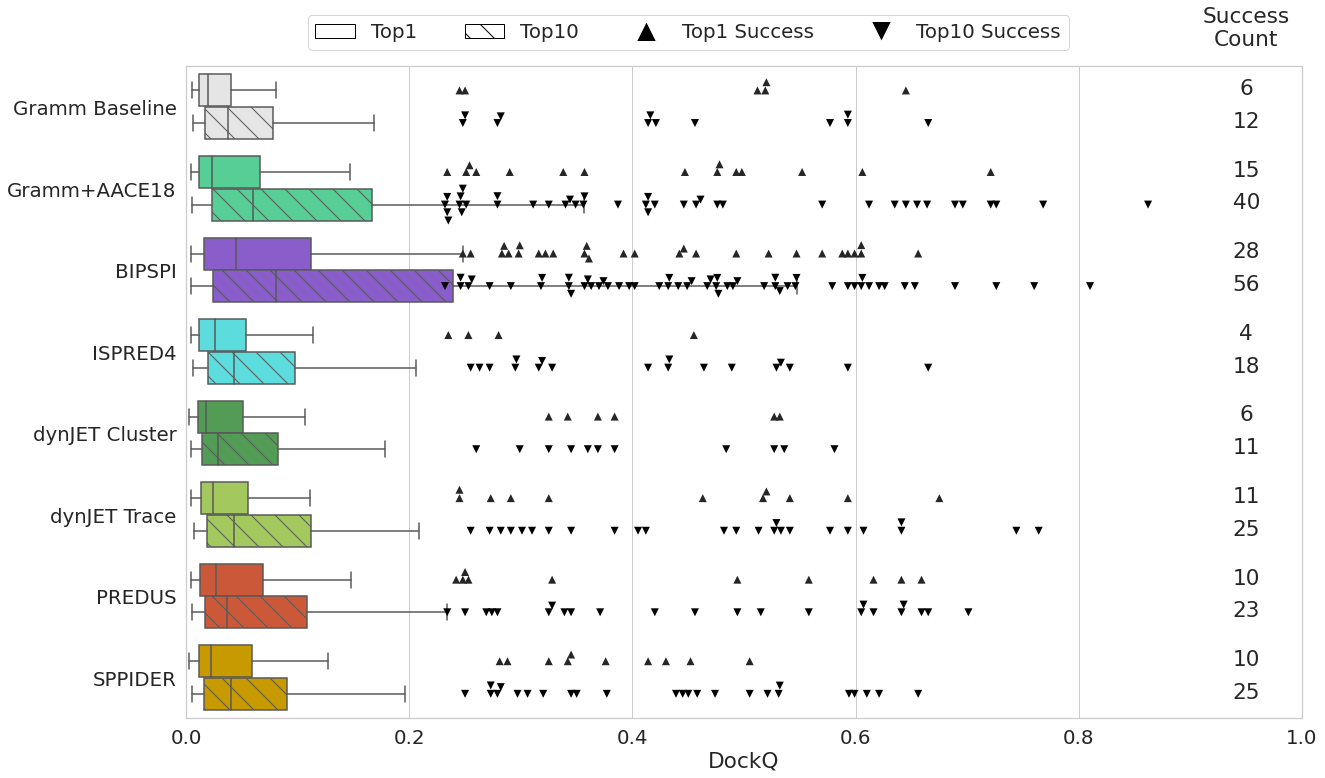

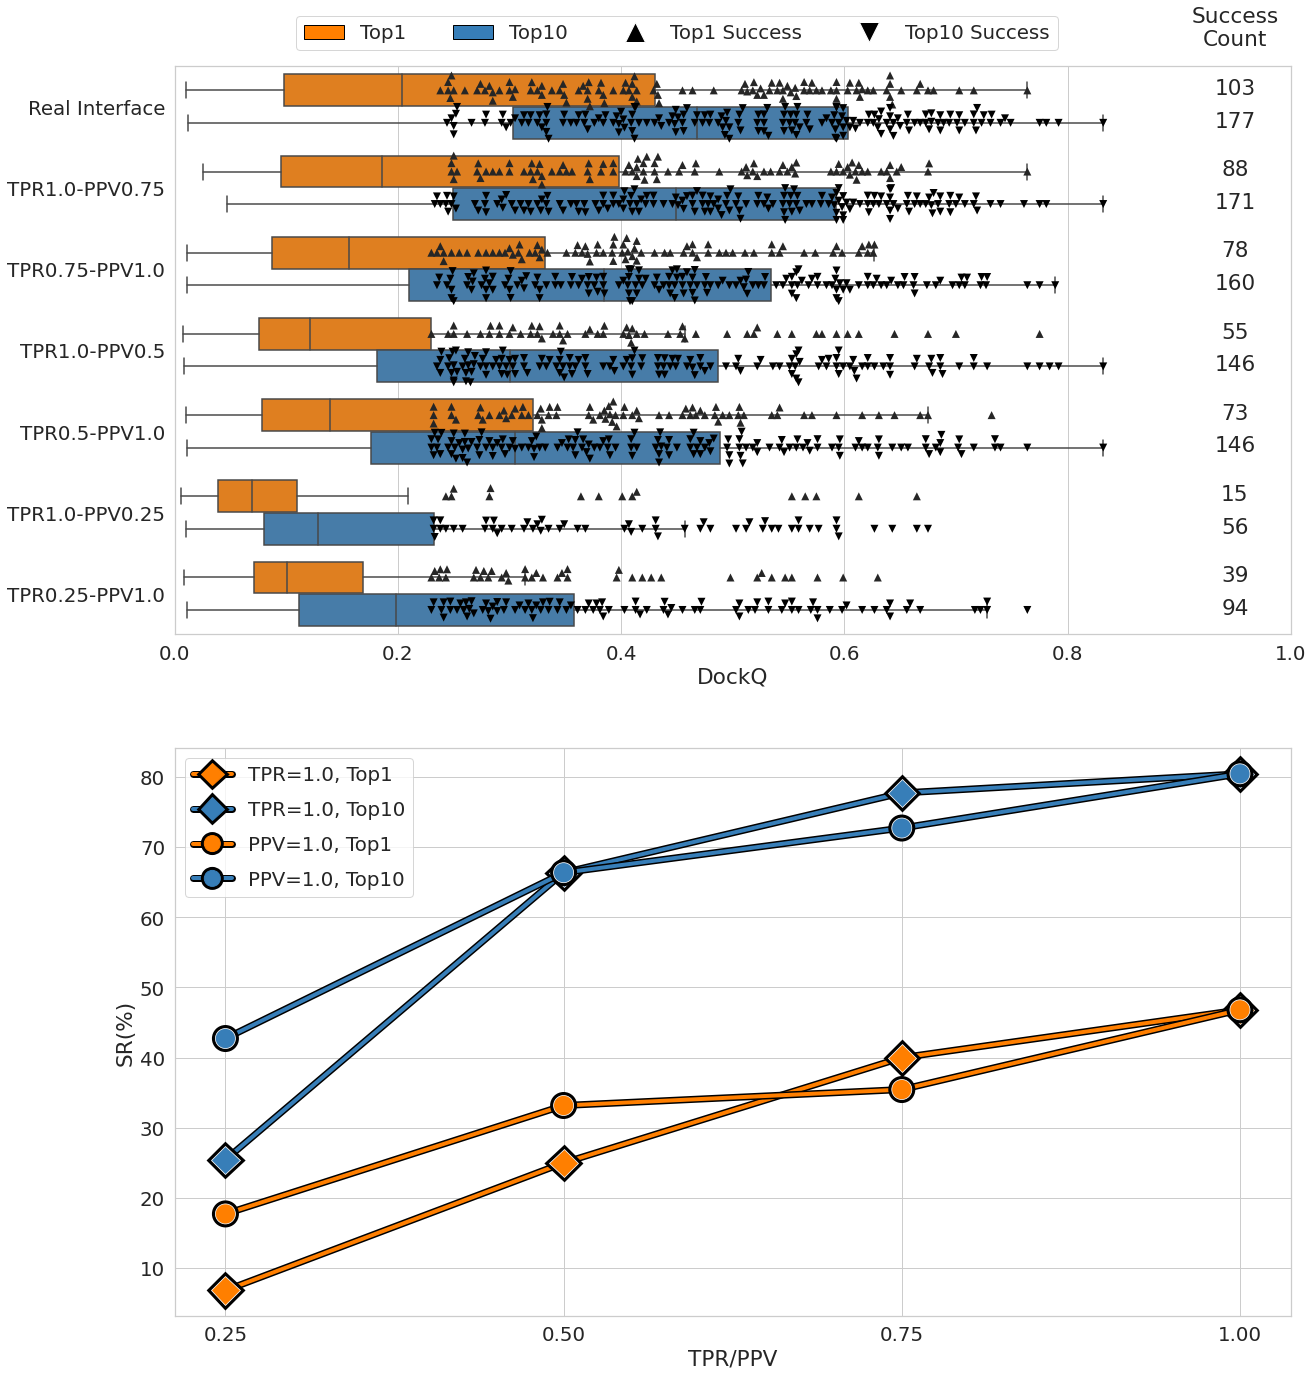

In [115]:
def compare_runs(runs):
    countdic = []
    bardic = {'DockQ':[], 'Setup':[], 'Top':[]}
    swarmdic = {'DockQ':[], 'Setup':[], 'Top':[]}
    for run in runs:
        top1dq = [dockqs[run][code][0] for code in dockqs[run]]
        top10dq = [max(dockqs[run][code][:10]) for code in dockqs[run]]
        
        countdic.append(len([1 for code in dockqs[run]\
            if dockqs[run][code][0] >= 0.23]))
        top1sr = countdic[-1]/2.2
        
        countdic.append(len([1 for code in dockqs[run]\
            if max(dockqs[run][code]) >= 0.23]))
        top10sr = countdic[-1]/2.2
        
        print ('{}&{}&{}&{}&{}&{}&{}&{}&{}\\\\'.format(name_refine[run], 
               round(st.median(top1dq), 2), round(st.mean(top1dq),2), 
               round(st.stdev(top1dq),2), round(top1sr,2),
               round(st.median(top10dq), 3), round(st.mean(top10dq),3),
               round(st.stdev(top10dq),3), round(top10sr,2)))
        
        for code in dockqs[run]:
            bardic['DockQ'].append(dockqs[run][code][0])
            bardic['Setup'].append(name_refine[run])
            bardic['Top'].append('Top1')
            bardic['DockQ'].append(max(dockqs[run][code]))
            bardic['Setup'].append(name_refine[run])
            bardic['Top'].append('Top10')
            if dockqs[run][code][0] >= 0.23:
                swarmdic['DockQ'].append(dockqs[run][code][0])
                swarmdic['Setup'].append(name_refine[run])
                swarmdic['Top'].append('Top1')
            if max(dockqs[run][code]) >= 0.23:
                swarmdic['DockQ'].append(max(dockqs[run][code]))
                swarmdic['Setup'].append(name_refine[run])
                swarmdic['Top'].append('Top10')
        if not name_refine[run] in swarmdic['Setup']:
            swarmdic['DockQ'].append(-1)
            swarmdic['Setup'].append(name_refine[run])
            swarmdic['Top'].append('Top1')
            swarmdic['DockQ'].append(-1)
            swarmdic['Setup'].append(name_refine[run])
            swarmdic['Top'].append('Top10')
    return bardic, swarmdic, countdic

def plot_rungroups(runs, axes):
    
    palette = palette3
    hue_order = ['Top1', 'Top10']
    sb.set_palette(palette=palette5)
    bardic, swarmdic, countdic = compare_runs(runs)
    
    if 'realb' in runs: 
        sb.set_palette(palette=palette1)
        palette = {'Top1':'C0', 'Top10':'C1' }
        
    sb.swarmplot(x='DockQ', y='Setup', hue='Top', data=swarmdic, color='Black', 
                 dodge=True, size=8, hue_order=hue_order, ax=axes)
    sb.boxplot(x='DockQ', y='Setup', data=bardic, hue='Top',
               showfliers=False, palette=palette, 
               hue_order=hue_order, ax=axes)
    axes.get_legend().remove()
    c = axes.collections
    for a in c[::2]:
        a.set_paths([tup_mk])
    for a in c[1::2]:
        a.set_paths([tdown_mk])
    
    for n, count in enumerate(countdic):
        if n%2 != 0: mod = 0.25
        else: mod = -0.15
        if n%2 != 0: n -= 1
        n /= 2
        axes.text(x=0.95, y=n+mod, s=count, ha='center')
    axes.set_xticks(np.arange(0, 1.1, 0.2))
    
    if 'BIP2' in runs:  
        colorcount = 0
        boxes = axes.findobj(matplotlib.patches.PathPatch)
        for n, box in enumerate(boxes):
            color = 'C'+str(colorcount)
            box.set_facecolor(color)
            if (n+1)%2 == 0: colorcount += 1
        
        hatches = ['', '\\']*8
        for hatch, patch in zip(hatches, axes.artists):
            patch.set_hatch(hatch)
    axes.text(x=0.95, y=-0.75, s='Success\nCount', ha='center')

    return countdic

fig, ax = plt.subplots(1,1)
a = ax.scatter([1,2],[3,4], marker='^')
b = ax.scatter([1,2],[3,4], marker='v')
tup_mk, = a.get_paths()
tdown_mk, = b.get_paths()
a.remove()
b.remove() 

fig, axes = plt.subplots(1, 1, figsize=(20, 12), sharex=True)

runs = ['base', 'aace', 'BIP2', 
        'ISP_SVM', 'JET_CL', 
        'JET_TR', 'PRE', 'SPP']

countdic = plot_rungroups(runs, axes)
handles = [Patch(edgecolor='Black', facecolor='White'), 
           Patch(edgecolor='Black', facecolor='White', hatch='\\'),
           Line2D([0], [0], marker='^', color='w', markerfacecolor='Black', markersize=20),
           Line2D([0], [0], marker='v', color='w', markerfacecolor='Black', markersize=20)]
plt.legend(handles, ['Top1', 'Top10', 'Top1 Success', 'Top10 Success'], loc='lower left', 
           bbox_to_anchor=(0.1, 1.01, 0.7, 0.1), ncol=4, mode="expand")
axes.set_xlim(0,1)
axes.set_xlabel('DockQ')
fig.savefig(bsfolder+'pictures/dockq_prediction_statistics.png')

fig, axes = plt.subplots(2, 1, figsize=(20, 23))
runs = ['realb', 'r1075', 'r0751', 
        'r105', 'r051', 'r1025', 'r0251']

countdic = plot_rungroups(runs, axes[0])
axes[0].set_xlim(0,1)
axes[0].set_xlabel('DockQ')
handles = [Patch(edgecolor='Black', facecolor='C0'), 
           Patch(edgecolor='Black', facecolor='C1'),
           Line2D([0], [0], marker='^', color='w', markerfacecolor='Black', markersize=20),
           Line2D([0], [0], marker='v', color='w', markerfacecolor='Black', markersize=20)]
axes[0].legend(handles, ['Top1', 'Top10', 'Top1 Success', 'Top10 Success'], loc='lower left', 
               bbox_to_anchor=(0.1, 1.01, 0.7, 0.1), ncol=4, mode="expand")

idx = 0
sb.set_palette(palette=palette1)
countdic = countdic[:2]+countdic
print (countdic)
dic = {'SR(%)':[], 'TPR/PPV':[], 'Setup':[]}
for v in [1, 1, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25]:
    dic['TPR/PPV'].append(v)
    dic['SR(%)'].append(countdic[idx]/2.2)
    idx += 1
    dic['TPR/PPV'].append(v)
    dic['SR(%)'].append(countdic[idx]/2.2)
    idx += 1
    if idx % 4 != 0: 
        dic['Setup'].append('TPR=1.0, Top1')
        dic['Setup'].append('TPR=1.0, Top10')
    else:
        dic['Setup'].append('PPV=1.0, Top1')
        dic['Setup'].append('PPV=1.0, Top10')
        
sb.set_palette(palette=palette1)
sb.lineplot(x='TPR/PPV', y='SR(%)', data=dic, hue='Setup', style='Setup', 
            dashes=False, markers=['D', 'D', 'o', 'o'], ms=20, lw=4, 
            palette=['C0', 'C1', 'C0', 'C1'], ax=axes[1],
            path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()])

################################         LABELS       #################################################
handles, labels = axes[1].get_legend_handles_labels()
handles = [Line2D([0], [0], marker='D', color='C0', markerfacecolor='C0', lw=4, markersize=16,
                  path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()]),
           Line2D([0], [0], marker='D', color='C1', markerfacecolor='C1', lw=4, markersize=16,
                  path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()]),
           Line2D([0], [0], marker='o', color='C0', markerfacecolor='C0', lw=4, markersize=16,
                  path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()]),
           Line2D([0], [0], marker='o', color='C1', markerfacecolor='C1', lw=4, markersize=16,
                  path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()])]

axes[1].legend(handles=handles, labels=labels, labelspacing=0.8)
axes[1].set_xticks([0.25,0.5,0.75,1.0]) 
fig.savefig(bsfolder+'pictures/dockq_simulated_statistics.png')

In [21]:
##### OVERLAP PREDICTION DRIVEN DOCKING SUCCESS / BASELINE DOCKING SUCCESS
dic = {}
for tag in tags:
    if tag in ['ISP_CRF', 'BIP2']: continue
    dic[tag] = 0

counts = []
for code in codelist:
    succ = []
    if code not in dockqs['base']: continue
    if max(dockqs['base'][code]) < 0.23: continue 
    for tag in tags:
        if tag in ['ISP_CRF', 'BIP1', 'BIP2']: continue
        if code not in dockqs[tag]: continue
        if max(dockqs[tag][code]) > 0.23: dic[tag] += 1

print (dic)

aace = []
bip2 = []
for code in codelist:
    aace.append(max(dockqs['aace'][code]))
    bip2.append(max(dockqs['BIP2'][code]))
    
print (round(spearmanr(aace, bip2)[0], 2))
    

{'ISP_SVM': 4, 'PRE': 4, 'JET_CL': 1, 'JET_TR': 7, 'SPP': 6}
0.38


Spearman
AUC 0.787 	 BIP2
AUC 0.496 	 ISP_SVM
AUC 0.633 	 PRE
AUC 0.573 	 JET_CL
AUC 0.648 	 JET_TR
AUC 0.589 	 SPP
Cases failing Top1 and succeeding in Top10:
BIP2 28
ISP_SVM 14
PRE 13
JET_CL 5
JET_TR 14
SPP 15


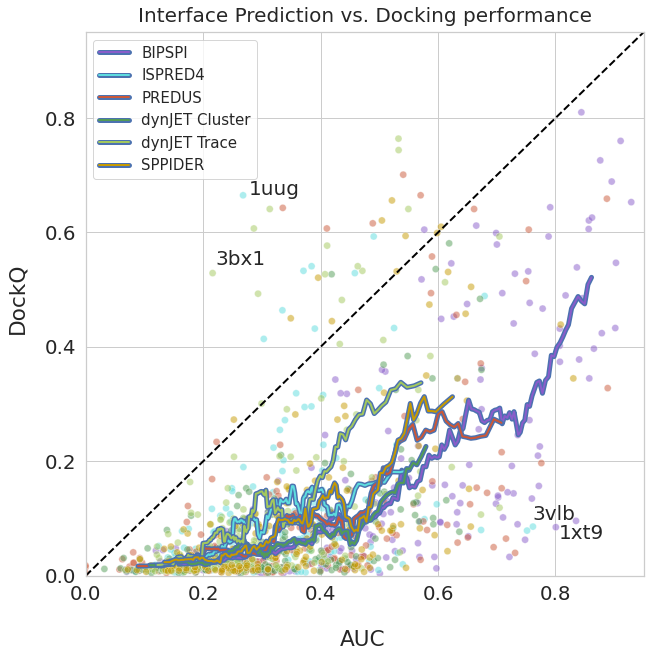

In [116]:
sb.set_palette(palette=palette3)
data = {'AUC':[], 'DockQ':[], 'Method':[]}
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

for tag in tags:
    for pdb in codelist:
        if pdb in method_fail: continue
        if not pdb in dockqs[tag]: continue
        if not pdb in metricdic[tag]: continue
        dockQ = max(dockqs[tag][pdb][:10])    
        data['DockQ'].append(dockQ)
        data['Method'].append(tag) 
        if tag == 'PRE': 
            data['AUC'].append(sum(metricdic[tag][pdb]['PPVs'][:2])/2)
        else:
            x = sum(metricdic[tag][pdb]['PR-AUC'][:2])/2
            #if x < 0.25 and dockQ > 0.5 and tag == 'JET_TR': print (pdb)
            if pdb == '1uug' and tag=='ISP_SVM':
                axes.annotate(pdb, size=20, xy=(x, dockQ), 
                              xytext=(x+0.01, dockQ))
                
            if pdb == '1xt9' and tag=='BIP2':
                axes.annotate(pdb, size=20, xy=(x, dockQ), 
                              xytext=(x+0.005, dockQ-0.02))
                
            if pdb == '3bx1' and tag=='JET_TR':
                axes.annotate(pdb, size=20, xy=(x, dockQ), 
                              xytext=(x+0.005, dockQ+0.015))
                
            if pdb == '3vlb' and tag=='ISP_SVM':
                axes.annotate(pdb, size=20, xy=(x, dockQ), 
                              xytext=(x+0.01, dockQ+0.018))
                
            data['AUC'].append(x)
        
sb.scatterplot(x='AUC', y='DockQ', hue='Method', alpha=0.5, 
               data=data, s=50, color=palette1[1], ax=axes)
axes.set_xticks(np.arange(0,0.9,0.2))
axes.set_yticks(np.arange(0,0.9,0.2))
axes.legend([],[], frameon=False)  
axes.set_xlabel('')
axes.set_ylabel('')

for tag in tags:
    count = 0
    dqlist = []
    avglist = []
    for pdb in codelist:
        if pdb in method_fail: continue
        if not pdb in dockqs[tag]: continue
        if not pdb in metricdic[tag]: continue
        dockQ = max(dockqs[tag][pdb][:10])
        if tag == 'PRE': 
            avglist.append([sum(metricdic[tag][pdb]['PPVs'][:2])/2, dockQ])
        else: 
            avglist.append([sum(metricdic[tag][pdb]['PR-AUC'][:2])/2, dockQ])
        count += 1
    avglist = np.array(avglist)
    avglist = avglist[avglist[:,0].argsort()]
    
    window = 20
    avgDQ = []
    avgAUC = []
    running = {'avg':[], 'avgdq':[]}
    for idx in range(len(avglist)):
        if len(avgDQ) < window:
            avgDQ.append(avglist[idx][1])
            avgAUC.append(avglist[idx][0])
        else:
            avgDQ = avgDQ[1:]+[avglist[idx][1]]
            avgAUC = avgAUC[1:]+[avglist[idx][0]]
            
        if len(avgDQ) == window:
            running['avg'].append(sum(avgAUC)/len(avgAUC))
            running['avgdq'].append(sum(avgDQ)/len(avgDQ))
            
    axes.plot(running['avg'], running['avgdq'], lw=2, label=name_refine[tag],
              path_effects=[pe.Stroke(linewidth=5, foreground='b'), pe.Normal()])
    
axes.set_title('Interface Prediction vs. Docking performance', 
               fontdict={'fontsize':20, 'verticalalignment': 'bottom'})

handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[:6], labels[:6], loc='upper left', 
            markerscale=2, fontsize=20, prop={'size':15})

axes.set_xlim(0,0.95)
axes.set_ylim(0,0.95)
fig.text(0.51, 0.05, 'AUC', ha='center', va='top')
fig.text(0.03, 0.51, 'DockQ', ha='center', va='center', rotation=90)
axes.plot([0, 1], [0, 1], ls="--", lw=2, color='black')
fig.savefig(bsfolder+'pictures/dockq_auc_comparison.png')

data = pd.DataFrame(data)
print ('Spearman')
for tag in tags:
    subdata = data.loc[data['Method']==tag]
    print ('AUC', round(spearmanr(subdata['AUC'], subdata['DockQ'])[0],3), '\t', tag)

print ('Cases failing Top1 and succeeding in Top10:')
for tag in tags:
    count = 0
    for code in codelist:
        if dockqs[tag][code][0] < 0.23 and max(dockqs[tag][code]) >= 0.23: count += 1
    print (tag, count)

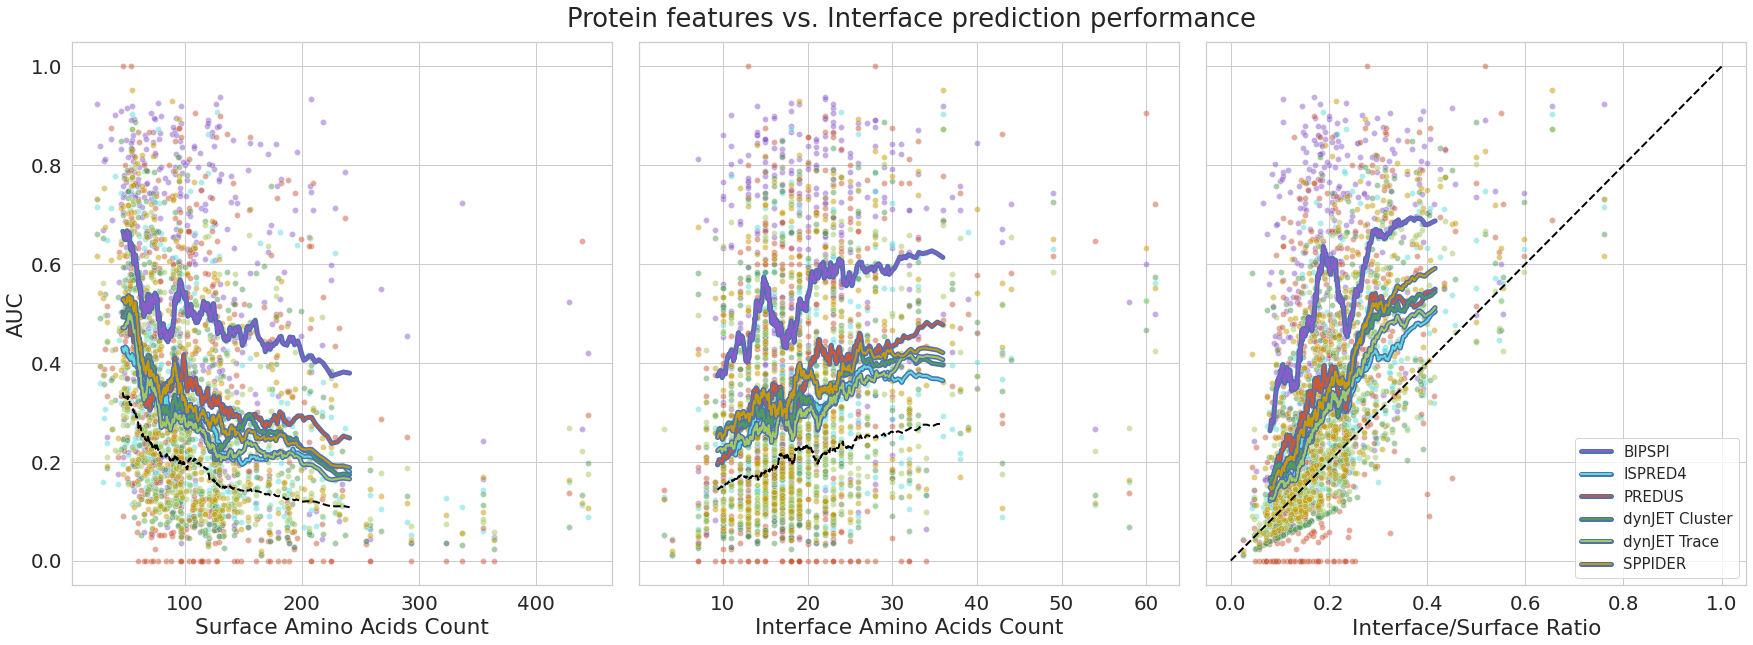

In [117]:
window = 50
sb.set_palette(palette=palette3)
fig, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=False, sharey=True)
p = PDBParser(QUIET=True)

def plt_running_avg(arr, axes, tag):
    LEN = []
    AUC = []
    running = {'LEN':[], 'AUC':[]}

    for idx in range(len(arr)):
        if len(LEN) < window:
            LEN.append(arr[idx][0])
            AUC.append(arr[idx][1])
        else:
            LEN = LEN[1:]+[arr[idx][0]]
            AUC = AUC[1:]+[arr[idx][1]]
            
        if len(LEN) == window:
            running['LEN'].append(sum(LEN)/len(LEN))
            running['AUC'].append(sum(AUC)/len(AUC))

    sb.scatterplot(x='Size', y='AUC', data=data, alpha=0.5, ax=axes)
    if tag != 'ratio': 
        axes.plot(running['LEN'], running['AUC'], lw=2, label=name_refine[tag],
                  path_effects=[pe.Stroke(linewidth=5, foreground='b'), pe.Normal()])
    else:
        axes.plot(running['LEN'], running['AUC'], ls="--", lw=2, c='black')

for tag in tags+['ratio']:
    arr = []
    data = {'Size':[], 'AUC':[]}
    if tag != 'ratio':
        if code not in dockqs[tag]: continue
    for code in codelist:
        if tag != 'ratio':
            data['Size'].append(surfaces[code][0])
            data['Size'].append(surfaces[code][1])
        if tag != 'PRE' and tag != 'ratio':
            arr.append([surfaces[code][0], metricdic[tag][code]['PR-AUC'][0]])
            arr.append([surfaces[code][1], metricdic[tag][code]['PR-AUC'][1]])
            data['AUC'].append(metricdic[tag][code]['PR-AUC'][0])
            data['AUC'].append(metricdic[tag][code]['PR-AUC'][1])
        elif tag == 'PRE':
            arr.append([surfaces[code][0], metricdic[tag][code]['PPVs'][0]])
            arr.append([surfaces[code][1], metricdic[tag][code]['PPVs'][1]])
            data['AUC'].append(metricdic[tag][code]['PPVs'][0])
            data['AUC'].append(metricdic[tag][code]['PPVs'][1])
        else: 
            arr.append([surfaces[code][0], interfaces[code][0]/surfaces[code][0]])
            arr.append([surfaces[code][1], interfaces[code][1]/surfaces[code][1]])
    
    arr = np.array(arr)
    arr = arr[arr[:,0].argsort()]
    plt_running_avg(arr, axes[0], tag)  
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Surface Amino Acids Count')

for tag in tags+['ratio']:
    arr = []
    data = {'Size':[], 'AUC':[]}
    if tag != 'ratio':
        if code not in dockqs[tag]: continue
    for code in codelist:
        if tag != 'ratio':
            data['Size'].append(interfaces[code][0])
            data['Size'].append(interfaces[code][1])
        if tag != 'PRE' and tag != 'ratio':
            arr.append([interfaces[code][0], metricdic[tag][code]['PR-AUC'][0]])
            arr.append([interfaces[code][1], metricdic[tag][code]['PR-AUC'][1]])
            data['AUC'].append(metricdic[tag][code]['PR-AUC'][0])
            data['AUC'].append(metricdic[tag][code]['PR-AUC'][1])
        elif tag == 'PRE':
            arr.append([interfaces[code][0], metricdic[tag][code]['PPVs'][0]])
            arr.append([interfaces[code][1], metricdic[tag][code]['PPVs'][1]])
            data['AUC'].append(metricdic[tag][code]['PPVs'][0])
            data['AUC'].append(metricdic[tag][code]['PPVs'][1])
        else: 
            arr.append([interfaces[code][0], interfaces[code][0]/surfaces[code][0]])
            arr.append([interfaces[code][1], interfaces[code][1]/surfaces[code][1]])
    
    arr = np.array(arr)
    arr = arr[arr[:,0].argsort()]
    plt_running_avg(arr, axes[1], tag)  
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Interface Amino Acids Count')

for tag in tags:
    arr = []
    data = {'Size':[], 'AUC':[]}
    if code not in dockqs[tag]: continue
    for code in codelist:
        data['Size'].append(interfaces[code][0]/surfaces[code][0])
        data['Size'].append(interfaces[code][1]/surfaces[code][1])
        if tag != 'PRE':
            arr.append([interfaces[code][0]/surfaces[code][0], metricdic[tag][code]['PR-AUC'][0]])
            arr.append([interfaces[code][1]/surfaces[code][1], metricdic[tag][code]['PR-AUC'][1]])
            data['AUC'].append(metricdic[tag][code]['PR-AUC'][0])
            data['AUC'].append(metricdic[tag][code]['PR-AUC'][1])
        else:
            arr.append([interfaces[code][0]/surfaces[code][0], metricdic[tag][code]['PPVs'][0]])
            arr.append([interfaces[code][1]/surfaces[code][1], metricdic[tag][code]['PPVs'][1]])
            data['AUC'].append(metricdic[tag][code]['PPVs'][0])
            data['AUC'].append(metricdic[tag][code]['PPVs'][1])

    arr = np.array(arr)
    arr = arr[arr[:,0].argsort()]
    plt_running_avg(arr, axes[2], tag)


    
handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(handles[:6], labels[:6], loc='lower right', markerscale=2, 
               fontsize=20, prop={'size':15})
axes[2].set_xlabel('Interface/Surface Ratio')
    
axes[2].plot([0, 1], [0, 1], ls="--", lw=2, color='black')
plt.text(x=-0.65, y=1.08, s='Protein features vs. Interface prediction performance', ha='center', size='large')
plt.subplots_adjust(wspace=0.05)
fig.savefig(bsfolder+'pictures/protein_features_auc_comparison.png')


Good
1ay7_u1 	 66 14 0.21 	 0.86 0.98062
1bvn_u1 	 218 23 0.11 	 0.89 0.99862
1clv_u1 	 208 22 0.11 	 0.93 0.99992
1eer_u1 	 127 23 0.18 	 0.92 0.5634
1he1_u1 	 96 21 0.22 	 0.85 0.99523
1i2m_u1 	 164 30 0.18 	 0.84 0.98661
1jk9_u1 	 123 18 0.15 	 0.87 0.94952
1jtd_u1 	 128 24 0.19 	 0.88 0.99768
1k5g_u1 	 171 31 0.18 	 0.82 0.70643
1r8s_u1 	 120 28 0.23 	 0.89 0.91017
1uug_u1 	 123 22 0.18 	 0.86 0.91664
1vrs_u1 	 73 14 0.19 	 0.87 0.86047
1wq1_u1 	 178 31 0.17 	 0.84 0.99502
1yu6_u1 	 130 22 0.17 	 0.94 0.97877
1yvb_u1 	 119 18 0.15 	 0.88 0.99167
1zlh_u1 	 141 24 0.17 	 0.85 0.95786
2bwe_u1 	 56 10 0.18 	 0.86 0.67591
2hrk_u1 	 108 16 0.15 	 0.83 0.9759
2i25_u1 	 75 15 0.2 	 0.89 0.99248
2sge_u1 	 97 14 0.14 	 0.92 0.99974
3bx1_u1 	 123 21 0.17 	 0.8 0.8721
3e2l_u1 	 125 28 0.22 	 0.84 0.94365
3vlb_u1 	 196 30 0.15 	 0.83 0.9998
4c6t_u1 	 93 16 0.17 	 0.9 0.54371
1ay7_u2 	 55 13 0.24 	 0.82 0.98062
1fq1_u2 	 100 20 0.2 	 0.8 0.99423
1gpw_u2 	 102 20 0.2 	 0.81 0.97839
1ib1_u2 	 98 2

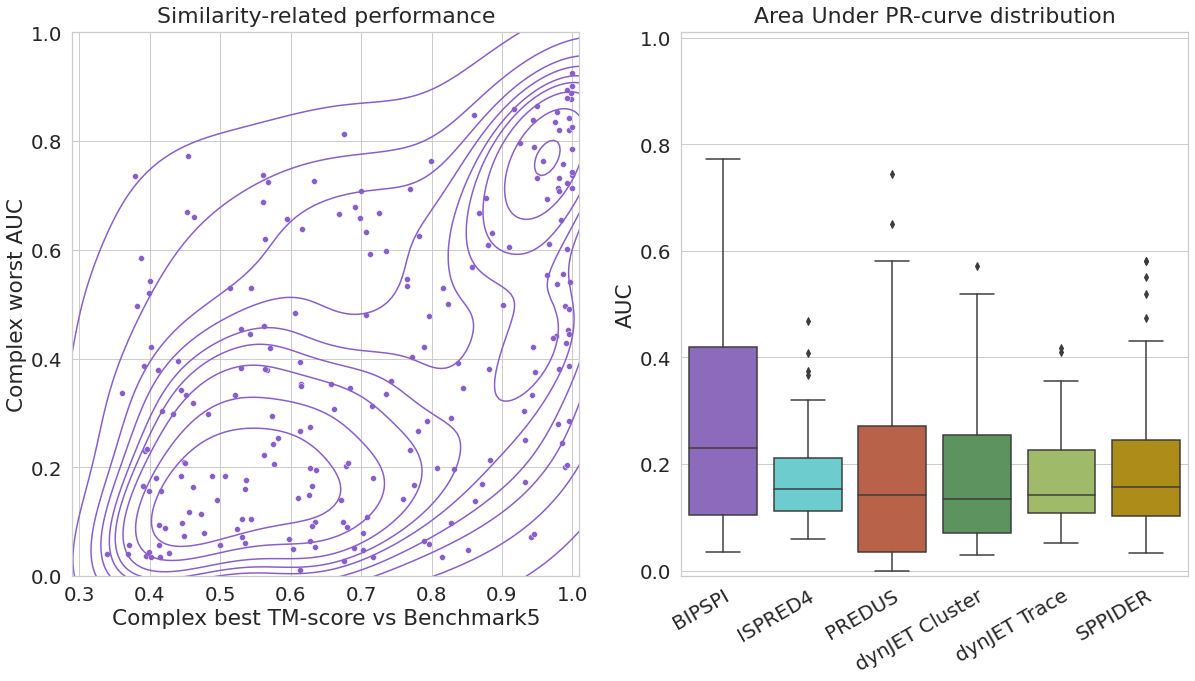

In [118]:
similarities = {line.split()[0]:[float(line.split()[1]), line.split()[2].strip()]\
                for line in open(bsfolder+'/data/all_similarities')}
acc = 0
count = 0
print ('Good')
for n in [0, 1]:
    for code in codelist:
        if interfaces[code][n]/surfaces[code][n] > 0.1\
        and interfaces[code][n]/surfaces[code][n] < 0.25\
        and metricdic['BIP2'][code]['PR-AUC'][n] > 0.8:
            print (code+'_u'+str(n+1), '\t', surfaces[code][n],\
                   int(interfaces[code][n]), round(interfaces[code][n]/surfaces[code][n],2),\
                   '\t', round(metricdic['BIP2'][code]['PR-AUC'][n],2), similarities[code][0])
            acc += similarities[code][0]
            count += 1
print ('Avg.', round(acc/count, 2))

acc = 0
count = 0
print ('\nBad')
for n in [0, 1]:
    for code in codelist:
        if interfaces[code][n]/surfaces[code][n] > 0.2\
        and interfaces[code][n]/surfaces[code][n] < 0.25\
        and metricdic['BIP2'][code]['PR-AUC'][n] < 0.3:
            print (code+'_u'+str(n+1), '\t', surfaces[code][n],\
                   int(interfaces[code][n]), round(interfaces[code][n]/surfaces[code][n],2),\
                   '\t', round(metricdic['BIP2'][code]['PR-AUC'][n],2), similarities[code][0])
            acc += similarities[code][0]
            count += 1
print ('Avg.', round(acc/count, 2))

aucs = [min(metricdic['BIP2'][code]['PR-AUC']) 
    for code in similarities if code in metricdic['BIP2']]
tmscores = [similarities[code][0] for code in similarities if code in metricdic['BIP2']]
print (spearmanr(aucs, tmscores))

dic={'AUC':[], 'Method':[]}
lowtm_codes = [code for code in similarities if code in metricdic['BIP2'] and float(similarities[code][0])<0.6]
for tag in tags:
    for code in lowtm_codes:
        if tag != 'PRE':
            dic['AUC'].append(min(metricdic[tag][code]['PR-AUC']))
            dic['Method'].append(name_refine[tag])
        else:
            dic['AUC'].append(min(metricdic[tag][code]['PPVs']))
            dic['Method'].append(name_refine[tag])

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sb.scatterplot(x=tmscores, y=aucs, ax=axes[0])
sb.kdeplot(x=tmscores, y=aucs, ax=axes[0])
axes[0].set_xlabel('Complex best TM-score vs Benchmark5')
axes[0].set_ylabel('Complex worst AUC')
axes[0].set_xlim(0.29,1.01)
axes[0].set_ylim(0,1)
 
g = sb.boxplot(x='Method', y='AUC', data=dic, ax=axes[1])
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=30, 
         ha="right", rotation_mode="anchor")
axes[0].set_title('Similarity-related performance', 
                  fontdict={'fontsize':22, 
                            'verticalalignment':'bottom'})

axes[1].set_ylabel('AUC')
axes[1].set_ylim(-0.01,1.01)
plt.subplots_adjust(wspace=0.2)
axes[1].set_title('Area Under PR-curve distribution', 
                  fontdict={'fontsize':22, 
                            'verticalalignment':'bottom'})
fig.savefig(bsfolder+'pictures/tm-score_auc_comparison.png')

In [119]:
##### DOCKING SUCCESS OVERLAP BETWEEN DIFFERENT PREDICTORS CONSTRAINTS
##### Top 10
bipsucc = set([code for code in codelist if max(dockqs['BIP2'][code])>=0.23])
presucc = set([code for code in codelist if max(dockqs['PRE'][code])>=0.23])
sppsucc = set([code for code in codelist if max(dockqs['SPP'][code])>=0.23])
svmsucc = set([code for code in codelist if max(dockqs['ISP_SVM'][code])>=0.23])
trsucc = set([code for code in codelist if max(dockqs['JET_TR'][code])>=0.23])
clsucc = set([code for code in codelist if max(dockqs['JET_CL'][code])>=0.23])

dic = {}
for code in codelist:
    count = 0
    if code in bipsucc: count += 1
    if code in presucc: count += 1
    if code in sppsucc: count += 1
    if code in svmsucc: count += 1
    if code in trsucc: count += 1
    if code in clsucc: count += 1
    if count not in dic: dic[count] = 0
    dic[count] += 1
print ('Top 10')
for n in range(1,6): print (n, dic[n])
    
    
##### Top 1    
bipsucc = set([code for code in codelist if dockqs['BIP2'][code][0]>=0.23])
presucc = set([code for code in codelist if dockqs['PRE'][code][0]>=0.23])
sppsucc = set([code for code in codelist if dockqs['SPP'][code][0]>=0.23])
svmsucc = set([code for code in codelist if dockqs['ISP_SVM'][code][0]>=0.23])
trsucc = set([code for code in codelist if dockqs['JET_TR'][code][0]>=0.23])
clsucc = set([code for code in codelist if dockqs['JET_CL'][code][0]>=0.23])

dic = {}
for code in codelist:
    count = 0
    if code in bipsucc: count += 1
    if code in presucc: count += 1
    if code in sppsucc: count += 1
    if code in svmsucc: count += 1
    if code in trsucc: count += 1
    if code in clsucc: count += 1
    if count not in dic: dic[count] = 0
    dic[count] += 1  
print ('Top 1')
for n in range(1,6): print (n, dic[n])

Top 10
1 38
2 26
3 11
4 5
5 3
Top 1
1 29
2 7
3 3
4 3
5 1


In [120]:
code = '1tmq'
for tag in tags:
    if tag != 'PRE': 
        print (tag.split('_')[-1], '\t', 
               round(dockqs[tag][code][0],2), '\t', 
               round(max(dockqs[tag][code]),2), '\t', 
               round(metricdic[tag][code]['PR-AUC'][0],2), '\t',
               round(metricdic[tag][code]['PR-AUC'][1],2))
    else: 
        print (tag, '\t', 
               round(dockqs[tag][code][0],2), '\t', 
               round(max(dockqs[tag][code]),2), '\t', 
               round(metricdic[tag][code]['PPVs'][0],2), '\t',
               round(metricdic[tag][code]['PPVs'][1],2))

BIP2 	 0.1 	 0.15 	 0.66 	 0.78
SVM 	 0.07 	 0.41 	 0.34 	 0.27
PRE 	 0.07 	 0.08 	 0.64 	 0.53
CL 	 0.01 	 0.01 	 0.05 	 0.53
TR 	 0.05 	 0.08 	 0.2 	 0.26
SPP 	 0.41 	 0.47 	 0.38 	 0.79


In [121]:
def fetch_preds(labelfile, n):
    chainscores = []
    isp = [float(line.split()[n]) if line.split()[n] != '1.0'
           else 0.99 for line in open(labelfile)]
    ist = [float(line.split()[1]) for line in open(labelfile)]
    rsa = [float(line.split()[0]) for line in open(labelfile)]
    for lp, lt, acc in zip(isp, ist, rsa):
        if acc >= 0.2: chainscores.append([lp, lt])
    return np.array(chainscores)

def manual_pr_stats(array, thr=0.1):    
    TP = FP = FN = TN = 0
    for pair in array: 
        if pair[0] >= thr: 
            if pair[1] == 1.0: TP += 1
            else: FP += 1
        else:
            if pair[1] == 1.0: FN += 1
            else: TN += 1               
    if TP+FP==0 or TP == 0: return TP/(TP+FN), '/'
    else: return TP/(TP+FN), TP/(TP+FP)

for code in singlecases:
    print ('######', code.upper())
    for tag in tags:
        if tag != 'PRE': 
            print (tag.split('_')[-1], '\t',
                   round(metricdic[tag][code]['PR-AUC'][0],2), '\t',
                   round(metricdic[tag][code]['PR-AUC'][1],2), '\t',
                   round(dockqs[tag][code][0],2), '\t', 
                   round(max(dockqs[tag][code]),2))
                   
        else: 
            print (tag, '\t',
                   round(metricdic[tag][code]['PPVs'][0],2), '\t',
                   round(metricdic[tag][code]['PPVs'][1],2), '\t',
                   round(dockqs[tag][code][0],2), '\t', 
                   round(max(dockqs[tag][code]),2))
    print ('######')
    


###### 1BVN
BIP2 	 0.89 	 0.92 	 0.09 	 0.43
SVM 	 0.36 	 0.54 	 0.04 	 0.09
PRE 	 0.53 	 0.17 	 0.07 	 0.1
CL 	 0.33 	 0.79 	 0.1 	 0.11
TR 	 0.2 	 0.62 	 0.52 	 0.58
SPP 	 0.23 	 0.68 	 0.07 	 0.09
######
###### 1HE1
BIP2 	 0.85 	 0.82 	 0.06 	 0.1
SVM 	 0.39 	 0.35 	 0.25 	 0.53
PRE 	 0.71 	 0.26 	 0.04 	 0.11
CL 	 0.67 	 0.32 	 0.06 	 0.07
TR 	 0.55 	 0.39 	 0.14 	 0.53
SPP 	 0.67 	 0.56 	 0.03 	 0.04
######
###### 1TMQ
BIP2 	 0.66 	 0.78 	 0.1 	 0.15
SVM 	 0.34 	 0.27 	 0.07 	 0.41
PRE 	 0.64 	 0.53 	 0.07 	 0.08
CL 	 0.05 	 0.53 	 0.01 	 0.01
TR 	 0.2 	 0.26 	 0.05 	 0.08
SPP 	 0.38 	 0.79 	 0.41 	 0.47
######
###### 1XT9
BIP2 	 0.71 	 0.89 	 0.09 	 0.09
SVM 	 0.25 	 0.75 	 0.23 	 0.33
PRE 	 0.78 	 1.0 	 0.33 	 0.33
CL 	 0.69 	 0.66 	 0.09 	 0.36
TR 	 0.68 	 0.67 	 0.1 	 0.11
SPP 	 0.48 	 0.83 	 0.15 	 0.15
######
###### 2ABZ
BIP2 	 0.78 	 0.38 	 0.15 	 0.16
SVM 	 0.15 	 0.32 	 0.14 	 0.16
PRE 	 0.35 	 0.47 	 0.25 	 0.25
CL 	 0.11 	 0.32 	 0.05 	 0.07
TR 	 0.24 	 0.35 	 0.01 	 0.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1he1 ISP_SVM [0.39412044496834475, 0.3477486746086253] [0.8494841138897401, 0.8204441439567298]
1xt9 ISP_SVM [0.2525666688457819, 0.7472077688558972] [0.7087075236439645, 0.8924025974025973]
1xt9 PRE [0.7777777777777778, 1.0] [0.7087075236439645, 0.8924025974025973]
2abz PRE [0.35294117647058826, 0.4666666666666667] [0.7792375729556037, 0.37995390106507]
3bx1 PRE [0.4444444444444444, 0.5333333333333333] [0.8010141617405044, 0.1693683837419921]
3prp PRE [0.5333333333333333, 0.7894736842105263] [0.679157627701317, 0.7421799628942486]
3lwn JET_CL [0.30067881284927755, 0.7958964793433936] [0.40373006623006624, 0.40432807664625936]
4ml7 JET_CL [0.5938171313171313, 0.6440721507012428] [0.7263980878111312, 0.4844922464108511]
4pj2 JET_CL [0.3267285072261453, 0.5109646222174069] [0.482651125608872, 0.20698836500854936]
1bvn JET_TR [0.19963561046460326, 0.6227175381138199] [0.8883308475699779, 0.915235313492986]
2nqd JET_TR [0.27279630185346665, 0.5997489149529414] [0.7960999665352866, 0.895494

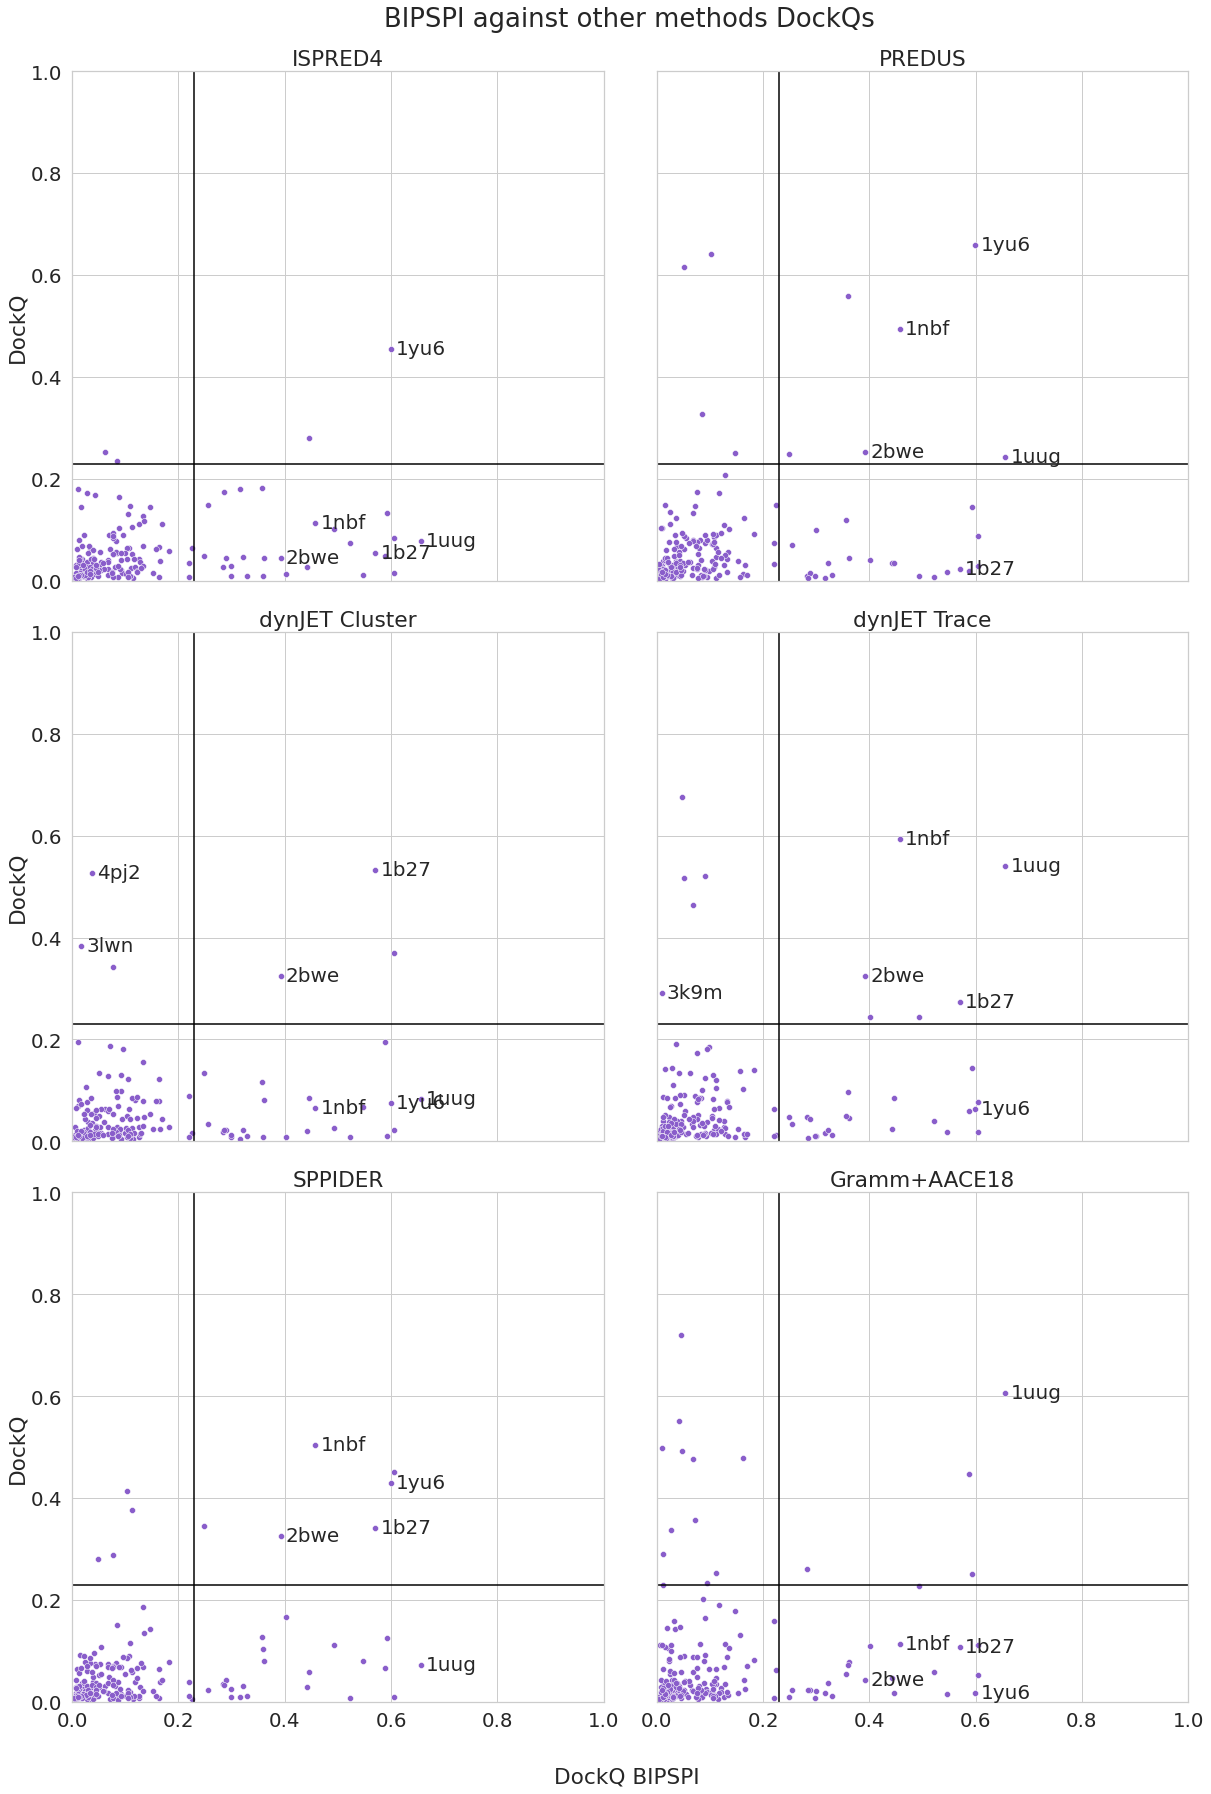

In [123]:
sb.set_palette(palette=palette3)
fig, axes = plt.subplots(3, 2, figsize=(20, 30), sharex=True, sharey=True)

r = c = 0
goodaltpreds = []
to_annotate = ['1b27', '1nbf', '1uug', '1yu6', '2bwe']
for n, tag in enumerate(tags+['aace']):
    if tag == 'BIP2': continue
    if c == 2: r += 1
    if c == 2: c = 0
    data = {'DockQ BIPSPI':[], 'DockQ':[], 'Method':[], 'Code':[]}
    for code in codelist:
        if code in dockqs[tag]:
            data['DockQ BIPSPI'].append(dockqs['BIP2'][code][0])
            data['DockQ'].append(dockqs[tag][code][0])
            data['Method'].append(tag)
            data['Code'].append(code)
            if dockqs[tag][code][0] >= 0.23 and dockqs['BIP2'][code][0] < 0.23 and tag != 'aace':
                goodaltpreds.append(code)
                if tag != 'PRE' and tag != 'aace':
                    print (code, tag,
                           metricdic[tag][code]['PR-AUC'],
                           metricdic['BIP2'][code]['PR-AUC'])
                elif tag != 'aace':
                    print (code, tag,
                           metricdic[tag][code]['PPVs'],
                           metricdic['BIP2'][code]['PR-AUC'])
                        
    sb.scatterplot(x='DockQ BIPSPI', y='DockQ', data=data, 
                    color='C0', ax=axes[r][c])
    

    
    maxdq = 0
    mindq = None
    maxcode = ''
    mincode = ''
    for i, code in enumerate(data['Code']):
        if data['DockQ BIPSPI'][i] < 0.02 and data['DockQ'][i] >= 0.23:
            if mindq == None: 
                mindq = data['DockQ BIPSPI'][i]
                mincode = code
            else:
                if data['DockQ BIPSPI'][i] < mindq:
                    mindq = data['DockQ BIPSPI'][i]
                    mincode = code
    
    for i, code in enumerate(data['Code']):
        if code in to_annotate+[mincode] and tag != 'aace'\
        and (data['DockQ BIPSPI'][i] >= 0.23\
        or data['DockQ'][i] >= 0.23):
            axes[r][c].annotate(code, size=20,
                xy=(data['DockQ BIPSPI'][i], data['DockQ'][i]), 
                xytext=(data['DockQ BIPSPI'][i]+0.01, data['DockQ'][i]-0.01))
        elif code in to_annotate\
        and (data['DockQ BIPSPI'][i] >= 0.23\
        or data['DockQ'][i] >= 0.23):
            axes[r][c].annotate(code, size=20,
                xy=(data['DockQ BIPSPI'][i], data['DockQ'][i]), 
                xytext=(data['DockQ BIPSPI'][i]+0.01, data['DockQ'][i]-0.01))
        elif code == '4pj2' and tag == 'JET_CL':
            axes[r][c].annotate(code, size=20,
                xy=(data['DockQ BIPSPI'][i], data['DockQ'][i]), 
                xytext=(data['DockQ BIPSPI'][i]+0.01, data['DockQ'][i]-0.01))
            
    axes[r][c].set_xlabel('')
    axes[r][c].hlines(0.23, 0, 1, color='black')
    axes[r][c].vlines(0.23, 0, 1, color='black')
    axes[r][c].legend().remove()
    axes[r][c].set_title(name_refine[tag])
    axes[r][c].set_xlim(0,1)
    axes[r][c].set_ylim(0,1)
    c += 1

fig.text(0.51, 0.095, 'DockQ BIPSPI', ha='center', va='top')
fig.suptitle('BIPSPI against other methods DockQs', x=0.512, y=0.91)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
fig.savefig(bsfolder+'pictures/BIPSPI_vs_all_dockq_comparison.png')

print ('Non-BIPSPI successes:',len(set(goodaltpreds)))

In [124]:
##### CENTER OF MASS DISTANCE (DECOY-NATIVE) vs. DOCKQ
def mass_center(chain):
    coords = []
    for res in chain: 
        for atom in res:
            if atom.get_id() == 'CA':
                coords.append(atom.get_coord())
    coords = np.array(coords)
    return np.sum(coords, axis=0)/len(coords)

def get_int_size(ch, opp):
    oppatoms = [atom for res in opp for atom in res]
    ns = NeighborSearch(oppatoms)
    
    intids = []
    for res in ch: 
        for atom in res:
            center = atom.get_coord()
            neighbors = ns.search(center, 6, 'R')
            if len(neighbors) != 0:
                intids.append(res.get_id()[1])
                break
    return intids

def scry(mindq, maxdq, minint, maxint, mincom, maxcom):
    if dockq >= mindq and dockq <= maxdq\
    and int_distance >= minint and int_distance <= maxint\
    and distance >= mincom and distance <= maxcom:
        print (code, n, dockq, int_distance, distance)

dataall = {'Method':[], 'DockQ':[], 'CoM distance':[], 'Int.CoM distance':[]}
datatop1 = {'Method':[], 'DockQ':[], 'CoM distance':[], 'Int.CoM distance':[]}
datatop10 = {'Method':[], 'DockQ':[], 'CoM distance':[], 'Int.CoM distance':[]}
p = PDBParser(QUIET=True)
for code in codelist: 
    unbound = bsfolder+'data/processed_b4/'+code+'_uc.pdb'
    nat_str = p.get_structure('', unbound)
    receptor = unfold_entities(nat_str[0]['A'], 'R')
    nat_res = unfold_entities(nat_str[0]['B'], 'R')
    intidx = get_int_size(nat_res, receptor)
    nat_int = [res for res in nat_res if res.get_id()[1] in intidx]
    nat_center = mass_center(nat_res)
    nat_int_center = mass_center(nat_int)
    for run in [1]:#,13,15,16,17,18]:
        for n in range(1, 11):
            decoy = bsfolder+'results/dock{}/{}_{}.pdb'.format(run, code, n)
            decoy_str = p.get_structure('', decoy)
            decoy_res = unfold_entities(decoy_str[0]['B'], 'R')
            decoy_int = [res for res in decoy_res if res.get_id()[1] in intidx]
            decoy_center = mass_center(decoy_res)
            decoy_int_center = mass_center(decoy_int)
            dockq = dockqs[postag[run]][code][n-1]
            distance = np.sqrt(np.sum((nat_center-decoy_center)**2))
            int_distance = np.sqrt(np.sum((nat_int_center-decoy_int_center)**2))
            distance_delta = distance-int_distance
            if distance_delta > 10: distance_delta = 10
            if distance_delta < -10: distance_delta = -10   
            dataall['DockQ'].append(dockq)
            dataall['CoM distance'].append(distance)
            dataall['Int.CoM distance'].append(int_distance)
            dataall['Method'].append(postag[run])
            
            if n == 1:
                datatop1['DockQ'].append(dockq)
                datatop1['CoM distance'].append(distance)
                datatop1['Int.CoM distance'].append(int_distance)
                datatop1['Method'].append(postag[run])
            
            if dockq == max(dockqs[postag[run]][code]):
                datatop10['DockQ'].append(dockq)
                datatop10['CoM distance'].append(distance)
                datatop10['Int.CoM distance'].append(int_distance)
                datatop10['Method'].append(postag[run])

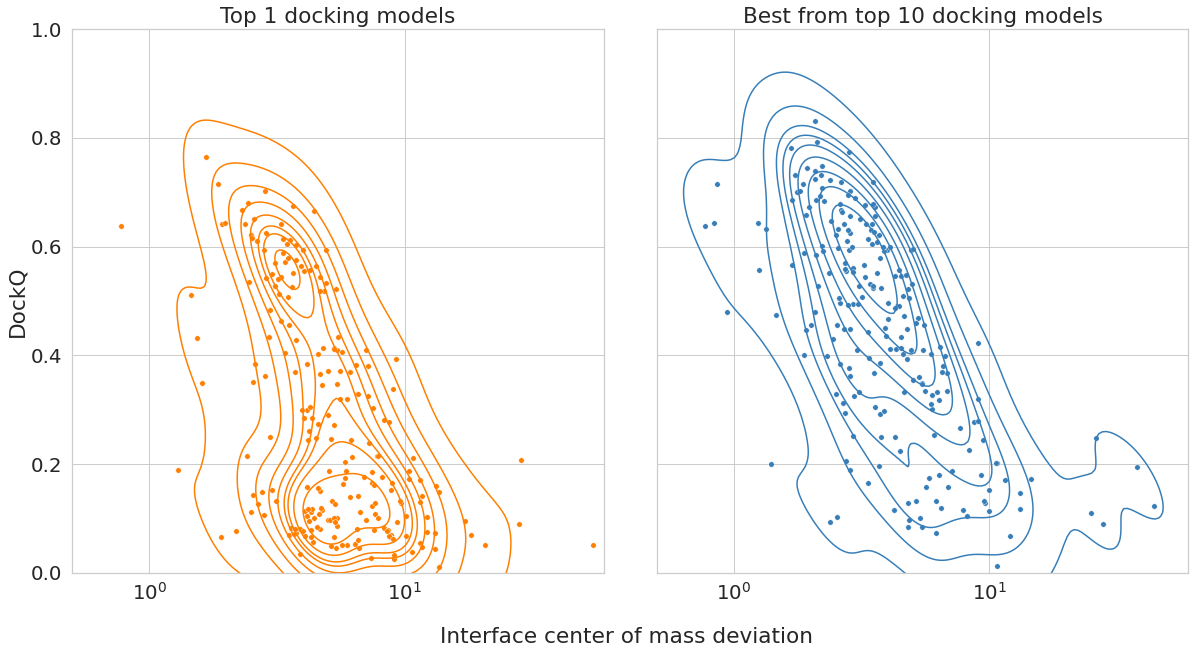

In [127]:
sb.set_palette(palette=palette1)
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
sb.scatterplot(x='Int.CoM distance', y='DockQ', data=datatop1, s=30, color='C0', ax=axes[0])
sb.scatterplot(x='Int.CoM distance', y='DockQ', data=datatop10, s=30, color='C1', ax=axes[1])

sb.kdeplot(x='Int.CoM distance', y='DockQ', data=datatop1, color='C0', log_scale=(True,False), ax=axes[0])
sb.kdeplot(x='Int.CoM distance', y='DockQ', data=datatop10, color='C1', log_scale=(True,False), ax=axes[1])

axes[0].set_xlim(0.5,60)
axes[0].set_ylim(0,1)
axes[1].set_xlim(0.5,60)
axes[1].set_ylim(0,1)
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[0].title.set_text('Top 1 docking models')
axes[1].title.set_text('Best from top 10 docking models')
fig.text(0.51, 0.05, 'Interface center of mass deviation', ha='center', va='top')
plt.subplots_adjust(wspace=0.1)
fig.savefig(bsfolder+'pictures/real_interfaces_docking_CoM_deviation.png')